In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import fields, replace, asdict
import scipy

# analytics
import sys
sys.path.insert(0,'../../') # just for jupyter  notebook
from stochvolmodels.MLE_estimator import hawkes_jd

import warnings
warnings.filterwarnings('ignore')

2023-12-22 16:54:43.249590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def jump_compensators(nu, eta, side):
    if side == 'p':
        return np.exp(nu)/(1-eta)-1
    elif side == 'm':
        return np.exp(nu)/(1+eta)-1

positive_jump_compensator = lambda nu_p, eta_p: jump_compensators(nu_p, eta_p, 'p')
negative_jump_compensator = lambda nu_m, eta_m: jump_compensators(nu_m, eta_m, 'm')


In [4]:
# Read P params
P_params = pd.read_csv('P_params.csv', index_col=0)
P_params.index = pd.Series(P_params.index).apply(lambda x: x[:10])
P_params.index = pd.to_datetime(P_params.index)

In [5]:
ticker = 'BTC'
freq = 'D'

df = pd.read_csv('../../../resources/deribit/BTC-spot-combined.csv')
_id = pd.to_datetime(df.timestamp).apply(lambda x: x.hour) == 9

df = df.loc[_id, :]
df.timestamp = df.timestamp.apply(lambda x: x[:10])
df.timestamp = pd.to_datetime(df.timestamp)
price = df.spot
price.index = df.timestamp

returns = np.log(price/price.shift(1))[1:]

if freq == 'D':  
    dt = 1/365

elif freq == 'W':
    dt = 1/365*7
    
MLE_estimator_daily = hawkes_jd.Hawkes_MLE_estimator(price)

In [6]:
nu_m = P_params.nu_m.iloc[0]
nu_p = P_params.nu_p.iloc[0]
MLE_estimator_daily.run_Peak_over_Thresholds(nu_m0=nu_m, nu_p0=nu_p, plug_in_nus=True)

# diffusion obs: 2466
# pos jumps obs: 185
# neg jumps obs: 209
Skewness of diffusion obs: 0.14862093958854553
Excess kurtosis of diffusion obs: -0.12204855295240069


In [8]:
theta_p = P_params.loc[:,'theta_p'].iloc[0]
theta_m = P_params.loc[:,'theta_m'].iloc[0]
kappa_p = P_params.loc[:,'kappa_p'].iloc[0]
kappa_m = P_params.loc[:,'kappa_m'].iloc[0]
beta11  = P_params.loc[:,'beta11'].iloc[0]
beta12  = P_params.loc[:,'beta12'].iloc[0]
beta21  = P_params.loc[:,'beta21'].iloc[0]
beta22  = P_params.loc[:,'beta22'].iloc[0]
eta_p   = P_params.loc[:,'eta_p'].iloc[0]
eta_m   = P_params.loc[:,'eta_m'].iloc[0]
nu_p    = P_params.loc[:,'nu_p'].iloc[0]
nu_m    = P_params.loc[:,'nu_m'].iloc[0]

mu = 0
sigma = P_params.sigma.iloc[0]

In [9]:
jump_size = pd.Series(np.zeros(len(returns)), index=returns.index)
jump_size.loc[returns >= nu_p] = returns.loc[returns >= nu_p]
jump_size.loc[returns <= nu_m] = returns.loc[returns <= nu_m]
jump_size.name = 'jump_size'

In [10]:
jumps_info = pd.concat([returns, jump_size], axis=1)

In [11]:
SECONDS_PER_YEAR = 365 * 24 * 60 * 60  # minute, seconds
jumps_info.loc[:,'t'] = pd.Series(jumps_info.index - jumps_info.index[0], index=jumps_info.index).apply(lambda x: x.total_seconds()/SECONDS_PER_YEAR)

In [12]:
_id = jumps_info.jump_size != 0 
jumps_info = jumps_info.loc[_id]

In [13]:
# Compute compensators
lambda_p_left_arr = [theta_p]
lambda_m_left_arr = [theta_m]

lambda_p_right_arr = [theta_p]
lambda_m_right_arr = [theta_m]

for i in range(1, len(jumps_info)):
    _T = jumps_info.t.iloc[i-1]
    _lambda_p_T_right = lambda_p_right_arr[-1]
    _lambda_m_T_right = lambda_m_right_arr[-1]

    T = jumps_info.t.iloc[i]
    jump_size = jumps_info.jump_size.iloc[i]
    lambda_p_T_left  = (_lambda_p_T_right - theta_p)*np.exp(-kappa_p*(T - _T)) + theta_p
    lambda_m_T_left  = (_lambda_m_T_right - theta_m)*np.exp(-kappa_m*(T - _T)) + theta_m

    if jump_size > 0:
        lambda_p_T_right = lambda_p_T_left + beta11*jump_size
        lambda_m_T_right = lambda_m_T_left + beta21*jump_size
    else:
        lambda_p_T_right = lambda_p_T_left + beta12*jump_size
        lambda_m_T_right = lambda_m_T_left + beta22*jump_size

    lambda_p_left_arr.append(lambda_p_T_left)
    lambda_m_left_arr.append(lambda_m_T_left)

    lambda_p_right_arr.append(lambda_p_T_right)
    lambda_m_right_arr.append(lambda_m_T_right)

jumps_info.loc[:,'lambda_p_left'] = lambda_p_left_arr
jumps_info.loc[:,'lambda_m_left'] = lambda_m_left_arr

jumps_info.loc[:,'lambda_p_right'] = lambda_p_right_arr
jumps_info.loc[:,'lambda_m_right'] = lambda_m_right_arr

# Get compensators, integrals of lambdas from last jump time to current jump time
comp_p = ( theta_p*(jumps_info.t-jumps_info.t.shift(1)) + (jumps_info.lambda_p_right.shift(1)-theta_p)/kappa_p*( 1 - np.exp(-kappa_p*(jumps_info.t-jumps_info.t.shift(1)) )  )  )
comp_m = ( theta_m*(jumps_info.t-jumps_info.t.shift(1)) + (jumps_info.lambda_m_right.shift(1)-theta_m)/kappa_m*( 1 - np.exp(-kappa_m*(jumps_info.t-jumps_info.t.shift(1)) )  )  )

jumps_info.loc[:,'comp_p'] = comp_p
jumps_info.loc[:,'comp_m'] = comp_m


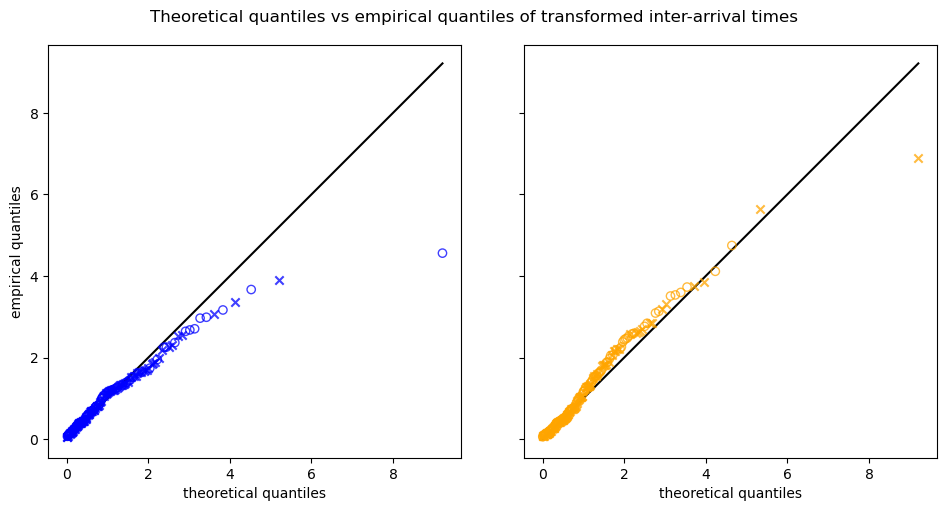

In [20]:
p_id = jumps_info.jump_size > 0 
m_id = jumps_info.jump_size < 0 

transformed_p_tau = jumps_info.comp_p.cumsum()[p_id].diff()
transformed_m_tau = jumps_info.comp_m.cumsum()[m_id].diff()

transformed_p_tau = transformed_p_tau.dropna()
transformed_m_tau = transformed_m_tau.dropna()

transformed_p_tau_q = transformed_p_tau.apply(lambda x: np.clip(np.mean(transformed_p_tau<=x), 0.00001,.9999))
transformed_m_tau_q = transformed_m_tau.apply(lambda x: np.clip(np.mean(transformed_m_tau<=x), 0.00001,.9999))

theo_tau_p = scipy.stats.expon.ppf(transformed_p_tau_q)
theo_tau_p = pd.Series(theo_tau_p, index=transformed_p_tau_q.index)

theo_tau_m = scipy.stats.expon.ppf(transformed_m_tau_q)
theo_tau_m = pd.Series(theo_tau_m, index=transformed_m_tau_q.index)

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

train_id_p = transformed_p_tau.index < '2019-05-30'
train_id_m = transformed_m_tau.index < '2019-05-30'

test_id_p = transformed_p_tau.index > '2019-05-30'
test_id_m = transformed_m_tau.index > '2019-05-30'

ax[0].scatter(theo_tau_p.loc[train_id_p], transformed_p_tau.loc[train_id_p], marker='o', color='blue', alpha=0.75, zorder=10, facecolors='none')
ax[1].scatter(theo_tau_m.loc[train_id_m], transformed_m_tau.loc[train_id_m], marker='o', color='orange', alpha=0.75, zorder=10, facecolors='none')

ax[0].scatter(theo_tau_p.loc[test_id_p], transformed_p_tau.loc[test_id_p], marker='x', color='blue', alpha=0.75, zorder=10)
ax[1].scatter(theo_tau_m.loc[test_id_m], transformed_m_tau.loc[test_id_m], marker='x', color='orange', alpha=0.75, zorder=10)

# plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))

all_tau = np.concatenate([theo_tau_p, transformed_p_tau, theo_tau_m, transformed_m_tau])
_max = np.nanmax(all_tau)
_min= np.nanmin(all_tau)
diag = np.linspace(_min,_max,100)

ax[0].plot(diag, diag, color='black')
ax[1].plot(diag, diag, color='black')
ax[0].set_xlabel('theoretical quantiles')
ax[1].set_xlabel('theoretical quantiles')

ax[0].set_ylabel('empirical quantiles')

ax[0].set(aspect='equal')
ax[1].set(aspect='equal')

fig.suptitle(r'Theoretical quantiles vs empirical quantiles of transformed inter-arrival times')

transformed_m_tau_sorted = transformed_m_tau.sort_values()
theo_tau_m_sorted = theo_tau_m.sort_values()

transformed_p_tau_sorted = transformed_p_tau.sort_values()
theo_tau_p_sorted = theo_tau_p.sort_values()

plt.tight_layout()
plt.savefig('QQ_plots.pdf', transparent=True, bbox_inches = 'tight')
